## 1. Dataset and input files
We are cell typing Xenium liver cancer dataset from 10x Genomics. The dataset is available on the 10x Genomics website under the Xenium datasets section.

Here is the link: https://www.10xgenomics.com/datasets/human-liver-data-xenium-human-multi-tissue-and-cancer-panel-1-standard

Download the dataset (you do not need to unzip it since the libraries written can handle unzipped dataset). Structure your working directory to have a sub-directory xenium_data such that the xenium_data directory tree would look like the following:

- /home/gddaslab/mxp140/xenium_liver_cancer/xenium_data/
    - diseased/
        - analysis_summary.html  
        - analysis.zarr.zip  
        - cell_feature_matrix.zarr.zip  
        - cells.zarr.zip  
        - experiment.xenium  
        - gene_panel.json  
        - morphology_mip.ome.tif  
        - transcripts.zarr.zip  
    - non_diseased/
        - analysis_summary.html  
        - analysis.zarr.zip  
        - cell_feature_matrix.zarr.zip  
        - cells.zarr.zip  
        - experiment.xenium  
        - gene_panel.json  
        - morphology_mip.ome.tif  
        - transcripts.zarr.zip  

2 directories, 16 files

A summary of the cells and gene statistics can already be found in the following link:

Diseased-> https://cf.10xgenomics.com/samples/xenium/1.9.0/Xenium_V1_hLiver_cancer_section_FFPE/Xenium_V1_hLiver_cancer_section_FFPE_analysis_summary.html

Non-diseased-> https://cf.10xgenomics.com/samples/xenium/1.9.0/Xenium_V1_hLiver_nondiseased_section_FFPE/Xenium_V1_hLiver_nondiseased_section_FFPE_analysis_summary.html

<!-- To create visualizations like the one in the links, please see my other notebook page on data exploration: which can be found as `diseased_data_exploration.ipynb` and `non_diseased_data_exploration.ipynb` inside notebooks directory. -->
In this notebook, I will create anndata object for diseased and non-diseased dataset.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Set up the project environment:
# - Import required modules: os for file paths, sys for system-specific parameters, and warnings to manage warning messages.
# - Define the project_path variable, pointing to the user's home directory and the 'xenium_liver_cancer' folder.
# - Add the project_path to the system path so custom modules in this directory can be imported.
# - Suppress all warnings to keep the notebook output clean.
import os, sys, warnings
project_path = os.path.join(os.path.expanduser("~"), 'xenium_liver_cancer')
sys.path.append(project_path)
warnings.simplefilter(action="ignore", category=Warning)

In [3]:
#Import libraries for array and dataframe manipulation
import numpy as np
import pandas as pd
#Import anndata to read and write anndata object
import anndata as ad
#Import generic plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [4]:
#Import my libraries to read, write and organize zarr files specific to the file/project organization mentioned earlier
#For what each specific module is, refer to documentations in `~{project_path}/documents`
from cell_stat_loader import SpatialInfo
from feature_matrix_loader import FeatureMatrixLoader

In [5]:
with FeatureMatrixLoader(f"{project_path}/xenium_data/diseased/cell_feature_matrix.zarr.zip") as loader:
    cell_by_feature = loader.load_cell_by_feature(format='csr') #load cell by feature matrix in sparse format
    attributes = loader.get_attributes() #attributes from the cell_features/.zattrs file
    print(attributes.keys())

dict_keys(['feature_ids', 'feature_keys', 'feature_types', 'major_version', 'minor_version', 'number_cells', 'number_features'])


In [5]:
print(f"The number of cells is {cell_by_feature.shape[0]}, which is same as reported in attributes: {attributes['number_cells']}.")
print(f"The number of features is {cell_by_feature.shape[1]}, which is same as reported in attributes: {attributes['number_features']}.")

The number of cells is 162628, which is same as reported in attributes: 162628.
The number of features is 539, which is same as reported in attributes: 539.


feature_types            
gene                         474
negative_control_codeword     41
negative_control_probe        20
unassigned_codeword            3
aggregate_gene                 1
Name: count, dtype: int64


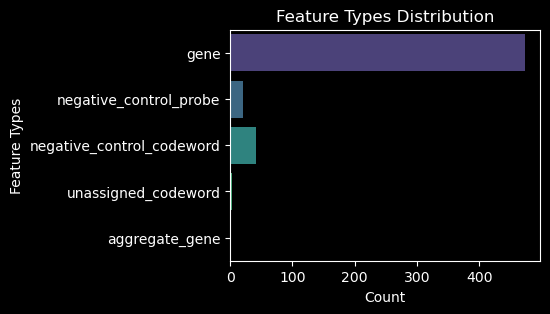

In [6]:
print(pd.DataFrame({'feature_types': attributes['feature_types']}).value_counts())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
sns.countplot(attributes['feature_types'], ax=ax, palette='viridis')
ax.set_xlabel('Count')
ax.set_ylabel('Feature Types')
ax.set_title('Feature Types Distribution')
plt.show()

In [7]:
print(f'As you may see that there are actually only {int(sum(np.array(attributes['feature_types'], dtype=str) == "gene"))} genes.')
print(f'Also the last feature which is `aggregated_gene` in fact is total_transcripts for the corresponding cell.')

As you may see that there are actually only 474 genes.
Also the last feature which is `aggregated_gene` in fact is total_transcripts for the corresponding cell.


Below I create an anndata object of the diseased dataset. This way we can control the size of the anndata by only including what is needed. To start we may create an anndata object of all the informations we have, read it, subset it and maybe even delete the full anndata from the notebook after subsetting to create memory to run the notebook.

In [8]:
gene_indices = np.where(np.array(attributes['feature_types'], dtype=str) == 'gene')[0]
aggregate_gene_indices = np.where(np.array(attributes['feature_types'], dtype=str) == 'aggregate_gene')[0]
liver_cancer_path = '../xenium_data/diseased/cells.zarr.zip' 
cell_spatial = SpatialInfo(f'{project_path}/xenium_data/diseased/cells.zarr.zip')#Load spatial data into SpatialInfo Class
number_of_cells = attributes['number_cells']
xenium_obj = ad.AnnData(cell_by_feature[:, gene_indices], 
                        obs = {'cell_id_in_hex':[cell_spatial.get_cell_id_in_hex(i) for i in range(number_of_cells)],
                               'cell_id_in_int':[cell_spatial.get_cell_id_in_int(i) for i in range(number_of_cells)],
                               'cell_area':[cell_spatial.get_cell_area(i) for i in range(number_of_cells)],
                               'nucleus_area':[cell_spatial.get_nucleus_area(i) for i in range(number_of_cells)],
                               'total_transcripts': cell_by_feature[:, aggregate_gene_indices].toarray()[:, 0].tolist()},
                        var = {'ensembl_id': np.array(attributes['feature_ids'])[gene_indices], 
                               'gene_symbol': np.array(attributes['feature_keys'])[gene_indices]},
                        obsm = {'cell_location':np.array([(arr[0], arr[1]) for i in range(number_of_cells) for arr in [cell_spatial.get_cell_loc(i)]]),
                                'nucleus_location':np.array([(arr[0], arr[1]) for i in range(number_of_cells) for arr in [cell_spatial.get_nucleus_loc(i)]])})
#Lets log1p normalize the data as well. First we save the raw/original counts in a layer called raw_counts.
xenium_obj.layers["raw_counts"] = xenium_obj.X.copy()
xenium_obj

AnnData object with n_obs × n_vars = 162628 × 474
    obs: 'cell_id_in_hex', 'cell_id_in_int', 'cell_area', 'nucleus_area', 'total_transcripts'
    var: 'ensembl_id', 'gene_symbol'
    obsm: 'cell_location', 'nucleus_location'
    layers: 'raw_counts'

In [ ]:
#save anndata object for future purpose
xenium_obj.write_h5ad('liver_cancer.h5ad')

## Healthy liver: 

For healthy liver, we simply follow the same footsteps that we walked to create anndata object for liver cancer.

dict_keys(['feature_ids', 'feature_keys', 'feature_types', 'major_version', 'minor_version', 'number_cells', 'number_features'])
The number of cells is 239271, which is same as reported in attributes: 239271.
The number of features is 542, which is same as reported in attributes: 542.
feature_types            
gene                         377
unassigned_codeword          103
negative_control_codeword     41
negative_control_probe        20
aggregate_gene                 1
Name: count, dtype: int64


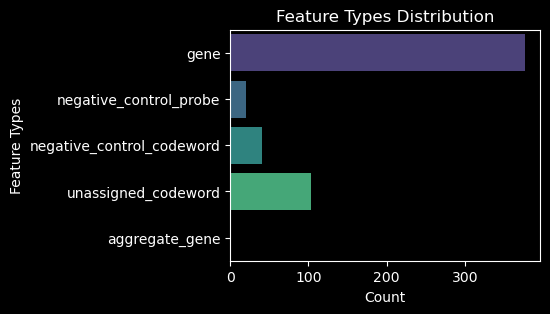

As you may see that there are actually only 377 genes.
Also the last feature which is `aggregated_gene` in fact is total_transcripts for the corresponding cell.


AnnData object with n_obs × n_vars = 239271 × 377
    obs: 'cell_id_in_hex', 'cell_id_in_int', 'cell_area', 'nucleus_area', 'total_transcripts'
    var: 'ensembl_id', 'gene_symbol'
    obsm: 'cell_location', 'nucleus_location'
    layers: 'raw_counts'

In [ ]:
with FeatureMatrixLoader(f"{project_path}/xenium_data/non_diseased/cell_feature_matrix.zarr.zip") as loader:
    cell_by_feature = loader.load_cell_by_feature(format='csr') #load cell by feature matrix in sparse format
    attributes = loader.get_attributes()
    print(attributes.keys())

print(f"The number of cells is {cell_by_feature.shape[0]}, which is same as reported in attributes: {attributes['number_cells']}.")
print(f"The number of features is {cell_by_feature.shape[1]}, which is same as reported in attributes: {attributes['number_features']}.")

print(pd.DataFrame({'feature_types': attributes['feature_types']}).value_counts())
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
sns.countplot(attributes['feature_types'], ax=ax, palette='viridis')
ax.set_xlabel('Count')
ax.set_ylabel('Feature Types')
ax.set_title('Feature Types Distribution')
plt.show()

print(f'As you may see that there are actually only {int(sum(np.array(attributes['feature_types'], dtype=str) == "gene"))} genes.')
print(f'Also the last feature which is `aggregated_gene` in fact is total_transcripts for the corresponding cell.')

gene_indices = np.where(np.array(attributes['feature_types'], dtype=str) == 'gene')[0]
aggregate_gene_indices = np.where(np.array(attributes['feature_types'], dtype=str) == 'aggregate_gene')[0]
healthy_liver_path = f'{project_path}/xenium_data/non_diseased/cells.zarr.zip' 
cell_spatial = SpatialInfo(f'{healthy_liver_path}')
number_of_cells = attributes['number_cells']
healthy_obj = ad.AnnData(cell_by_feature[:, gene_indices], 
                        obs = {'cell_id_in_hex':[cell_spatial.get_cell_id_in_hex(i) for i in range(number_of_cells)],
                               'cell_id_in_int':[cell_spatial.get_cell_id_in_int(i) for i in range(number_of_cells)],
                               'cell_area':[cell_spatial.get_cell_area(i) for i in range(number_of_cells)],
                               'nucleus_area':[cell_spatial.get_nucleus_area(i) for i in range(number_of_cells)],
                               'total_transcripts': cell_by_feature[:, aggregate_gene_indices].toarray()[:, 0].tolist()},
                        var = {'ensembl_id': np.array(attributes['feature_ids'])[gene_indices], 
                               'gene_symbol': np.array(attributes['feature_keys'])[gene_indices]},
                        obsm = {'cell_location':np.array([(arr[0], arr[1]) for i in range(number_of_cells) for arr in [cell_spatial.get_cell_loc(i)]]),
                                'nucleus_location':np.array([(arr[0], arr[1]) for i in range(number_of_cells) for arr in [cell_spatial.get_nucleus_loc(i)]])})
#Lets log1p normalize the data as well. First we save the raw/original counts in a layer called raw_counts.
healthy_obj.layers["raw_counts"] = healthy_obj.X.copy()
healthy_obj.write_h5ad('healthy_liver.h5ad') #save anndata object
healthy_obj